# Recognising NRs


In [1]:
import sys
import os

wdirs = ["/mnt/data/Anastasia/Glass","/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/",
"/mnt/data/Anastasia/QDs_prelabsem1811/","/mnt/data/Anastasia/Initial/",
"/mnt/data/Anastasia/test_18_07_11_pd29_06_div12_WISSNR/"]

dfiles = []
for dirt in wdirs:
    basedir = dirt
    files = os.listdir(basedir)
    if dirt[-1] != '/':
        dirt = dirt+'/'
    for f in files:
        if f[-4:]=='.tif': 
            try:
                i = int(f[-5])
                dfiles.append(dirt+f)
            except:
                pass
cfile = dfiles[0]
wdir = ''
cf2 = cfile.split(".")[0].split("/")
for fs in cf2[:-1]:
    wdir = wdir+fs+'/'
wdir = wdir+cf2[-1]+'output/sptrack/'


In [2]:
cfile

'/mnt/data/Anastasia/Glass/field1_2.tif'

In [3]:
from numpy import *
from matplotlib.pylab import *
import scipy.optimize as opt
import pickle
from scipy.optimize import minimize,least_squares
from scipy.stats import linregress
%matplotlib inline

In [4]:
with open(wdir+'data_msd.pickle', 'rb') as handle:
    data = pickle.load(handle)


In [5]:
def bimod(x):
    m1 = mean(x)
    m2 = std(x)
    m3 = mean((x-m1)**3)/m2**3
    m4 = mean((x-m1)**4)/m2**4
    return((m3**2+1)/m4)

In [15]:
driftcorrected = True
dirt = wdir
basedir = dirt
files = os.listdir(basedir)

dfiles = []

if driftcorrected:
    for f in files:
        if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]=='DC': dfiles.append(basedir+f)
else:
    for f in files:
        if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]!='DC': dfiles.append(basedir+f)
    
dfiles.sort()

amps = []
for ni,name in enumerate(dfiles):
    popts = load(name)
    posx = popts[:,5]
    posy = popts[:,6]
    amp = popts[:,0]
    th = 0
    th2 = 13.0
    sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    Tf = len(posx)
    if sel.sum() > 1000:
        amps.append([mean(amp[sel]),mean(popts[sel,4]),bimod(amp[sel])])
    else:
        amps.append([0,0,0])
ampst = array(amps)


In [8]:
def conditionnumber(a,D):
    if a<0.1:
        return(0)
    if a>0.1 and a<0.4:
        return(1)
    if a>0.4 and a<1.0 and D<1e-2:
        return(2)
    if a>1.0 and a<3.0 and D>1e-2:
        return(3)
    if a>1.0 and a<3.0 and D<1e-2:
        return(4)
    if a>3.0:
        return(5)
    return(6)
    
def conditionlabel(i):
    if i==0:
        return("Amp/Bg<0.1")
    if i==1:
        return("0.1< Amp/Bg <0.4")
    if i==2:
        return("0.4< Amp/Bg <1.0 & D0<0.01 um2/s")
    if i==3:
        return("1< Amp/Bg <3 & D0>0.01 um2/s")
    if i==4:
        return("1< Amp/Bg <3 & D0<0.01 um2/s")
    if i==5:
        return("Amp/Bg>3")
    if i==6:
        return("Others")

#sel = (ampst[:,0]/ampst[:,1]>0.1)*(ampst[:,0]/ampst[:,1]<0.4)
#sel = (ampst[:,0]/ampst[:,1]>0.4)*(ampst[:,0]/ampst[:,1]<1.0)*(Des[:,0]<1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]>1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]<1e-2)
#sel0 = (ampst[:,0]/ampst[:,1]>3.0)
#conditionnumber(0.5,0.6)

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/

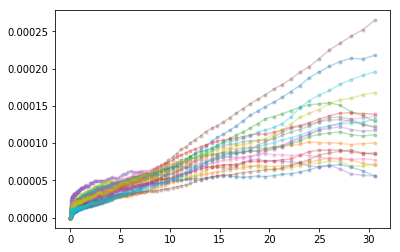

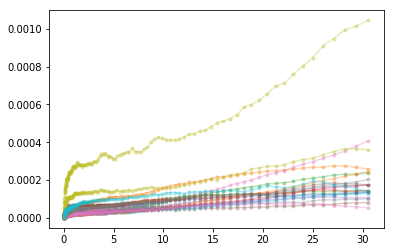

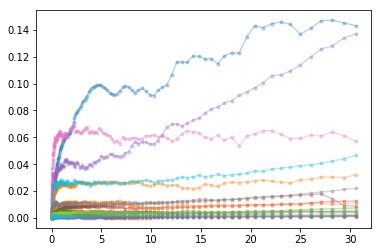

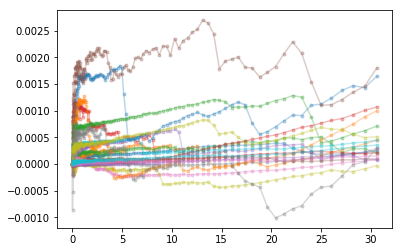

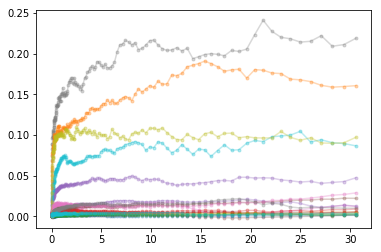

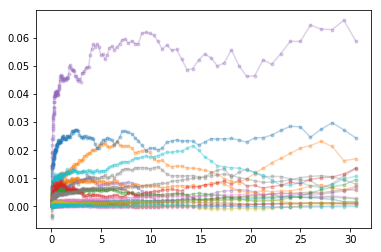

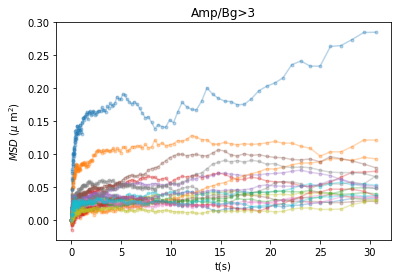

In [9]:
tmax = data[0][1].shape[0]

t = arange(tmax)


cmapt = get_cmap('tab20')

counter = zeros(7)
k = 0
for i in range(len(data)):
    d = data[i]
    ni,yt,ey2,cnt = d
   
    xtt = t*10.0e-3
    ytt = yt*.325**2
    
    dto =  log(tmax)/200
    tml = log(t[1:])
    ntl = int(tml[-1]/dto)+1
    t0l = 0
    dd = zeros((ntl,2))-1
    dd[0,:2] = (t[1],ytt[1])
    for il in arange(1,ntl):
        til = t0l+dto
        sel = (tml>=t0l)*(tml<til)
        if sel.sum()>0:
            xe = xtt[1:][sel]
            ye = ytt[1:][sel]
            dd[il,:2] = [mean(xe),mean(ye)]
        t0l = til

    dde = dd[dd[:,0]>0,:]
    dde = dde[1:,:]
    
    if i == 0:
        xde = column_stack((dde,dde[:,:1]*0+i))
        xden = column_stack((dde[:,:1],(dde[:,1:2]-dde[0,1])/(dde[-1,1]-dde[0,1]),dde[:,:1]*0+i))
    else:
        xde = row_stack((xde,column_stack((dde,dde[:,:1]*0+i))))
        xden = row_stack((xden,column_stack((dde[:,:1],(dde[:,1:2]-dde[0,1])/(dde[-1,1]-dde[0,1]),dde[:,:1]*0+i))))
        
    ntle = dde.shape[0]
    nwin = 50
    ds = zeros((ntle+nwin-3,3))
    for il in range(ntle+nwin-3):
        sel = arange(il-nwin+3,il+3)
        sel = sel[(sel>=0)*(sel<ntle)]
        xe = dde[sel,0]
        ye = dde[sel,1]    
        lm = linregress(xe,ye)
        ds[il,0] = mean(xe)    
        ds[il,1:3] = (lm.slope,lm.stderr)    
    
    #print(i)
    
    xt = ds
    xt = xt[xt[:,1]>0,:]
    De = array([mean(xt[xt[:,0]<1e-1,1]),exp(mean(log(xt[xt[:,0]<1e-1,1])))])

    ic = conditionnumber(ampst[i,0]/ampst[i,1],De[0])
    if counter[ic]< 20:
        figure(ic)
        plot(dde[:,0],dde[:,1]-dde[0,1],'.-',alpha=0.3,label=i)
        counter[ic] +=1

    if i == 0:
        xds = column_stack((ds,ds[:,:1]*0+i))
    else:
        xds = row_stack((xds,column_stack((ds,ds[:,:1]*0+i))))
        
xds = array(xds)
xde = array(xde)
xden = array(xden)

#yscale("log")
#xscale("log")

for ic in range(6):
    title(conditionlabel(ic))
    xlabel("t(s)")
    ylabel("$MSD$ ($\mu$ m$^2$)")


In [10]:

ts = array([100,200,400,800,1600,3200,6400,12800])/1000.0
xt = xde[abs(xde[:,-1]-i)<1e-3,0]
idxts = zeros(ts.shape[0],dtype=int)
idx = arange(xt.shape[0])
for i in range(len(ts)):
    idxts[i] = idx[argmin(abs(xt-ts[i]))]

alphas = zeros((len(data),7))
alphalm = zeros((len(data),2))

Des = zeros((len(data),3))
Dep = zeros((len(data),6))

for i in range(len(data)):
    xt = xds[abs(xds[:,-1]-i)<1e-3,:]
    xt = xt[xt[:,1]>0,:]
    try:
        De = array([mean(xt[xt[:,0]<2e-1,1]),mean(xt[xt[:,0]<2e-1,2]),max(xt[xt[:,0]<2e-1,2])])
        sel = (xt[:,0]>2e-1)*(xt[:,0]<1.5e0)
        De2 = array([mean(xt[sel,1]),mean(xt[sel,2]),max(xt[sel,2])])
        sel = (xt[:,0]>1.5e0)*(xt[:,0]<1.5e1)
        De3 = array([mean(xt[sel,1]),mean(xt[sel,2]),max(xt[sel,2])])

        xt = xde[abs(xde[:,-1]-i)<1e-3,:]    
        msds = xt[idxts,:]
        msds = msds[1:,:]/msds[:-1,:]
        alpha = log(msds[:,1])/log(msds[:,0])
        lm = linregress(log(msds[:,0]).cumsum(),alpha)
        alphas[i,:] = alpha
        alphalm[i,:] = (lm.slope,lm.intercept)
        Des[i,:] = De
        Dep[i,:] = concatenate((De2,De3))
    except:
        pass

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
import seaborn as sns
sns.set(style="white", color_codes=True)

In [12]:
De.shape

(3,)

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


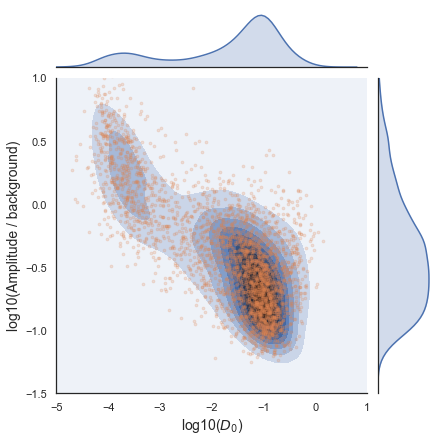

In [16]:
yt = ampst[:,0]/ampst[:,1]
yt = yt[ampst[:,0]!=0]
xt = Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

In [14]:
len(data)

3253

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


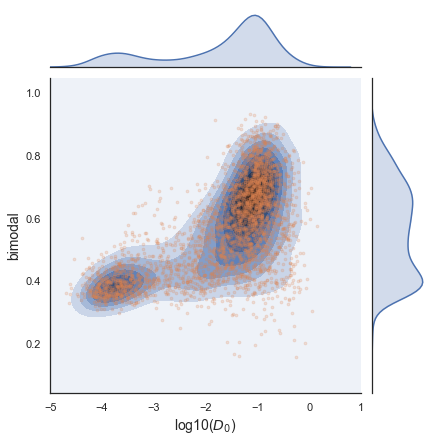

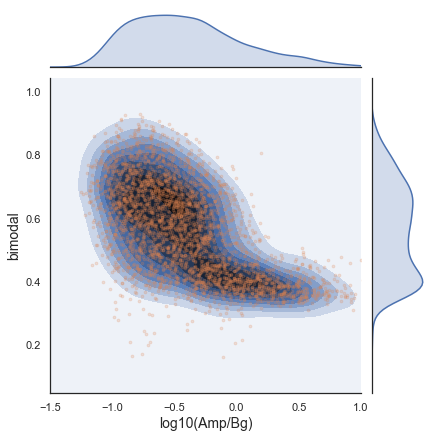

In [17]:
yt = 1.0*ampst[:,2]
yt = yt[ampst[:,0]!=0]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

#g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

yt = ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
#g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

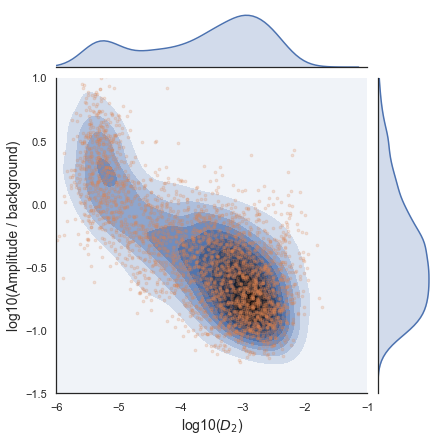

In [18]:
yt = ampst[:,0]/ampst[:,1]
yt = yt[ampst[:,0]!=0]

xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
fig = figure()
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

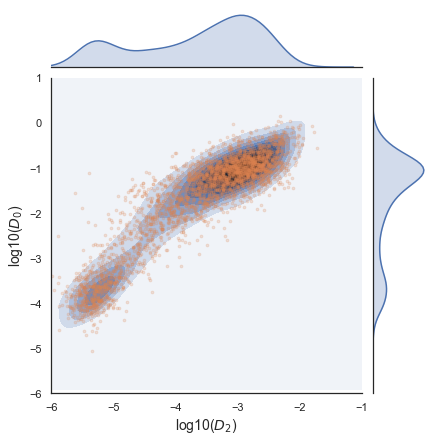

In [19]:
yt = Des[:,0]
xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-6,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10($D_0$)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

In [ ]:
ampst = 

In [22]:
yt = 1.0*ampst[:,0]/ampst[:,1]
yt = yt[ampst[:,0]!=0]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = log10(yt[sel])
sel0 = ampst[:,0]!=0


/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


NRs selected:  [3174 3115 1723]


Text(0.5,0,'t')

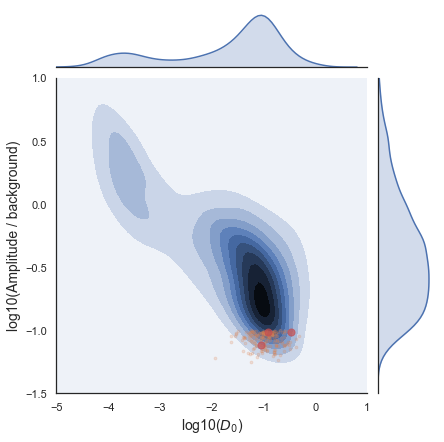

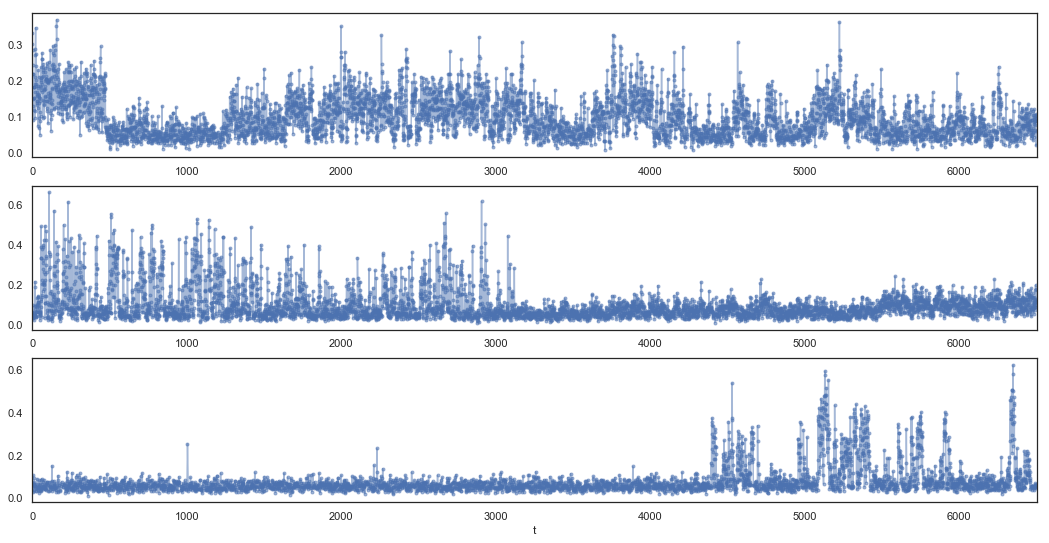

In [25]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = ampst[sel0,0]/ampst[sel0,1]<0.1

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)


it = permutation(arange(ampst.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)
print('NRs selected: ' ,it)

#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
#fig.title("Amplitude/Background < 0.1")
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [ 992 2502 1321]


Text(0.5,0,'t')

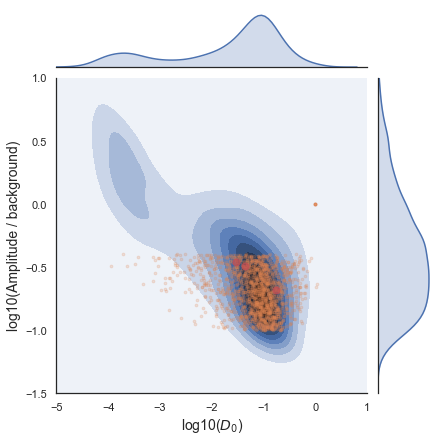

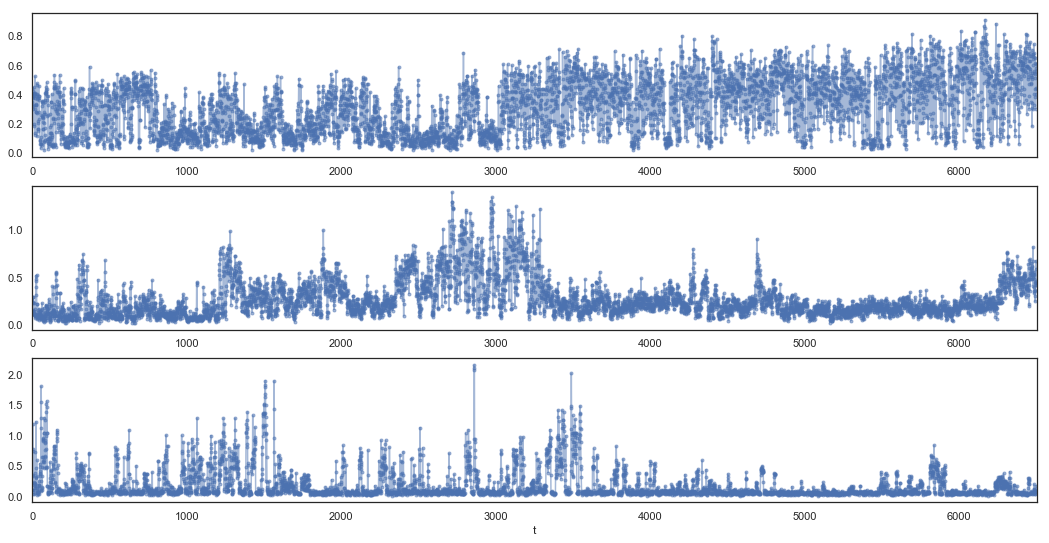

In [26]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[sel0,0]/ampst[sel0,1]>0.1)*(ampst[sel0,0]/ampst[sel0,1]<0.4)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(sel.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [ 384 2291 2284]


Text(0.5,0,'t')

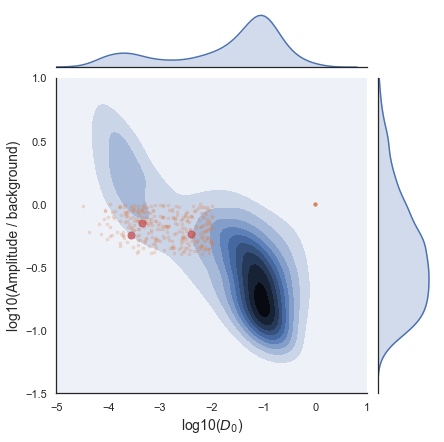

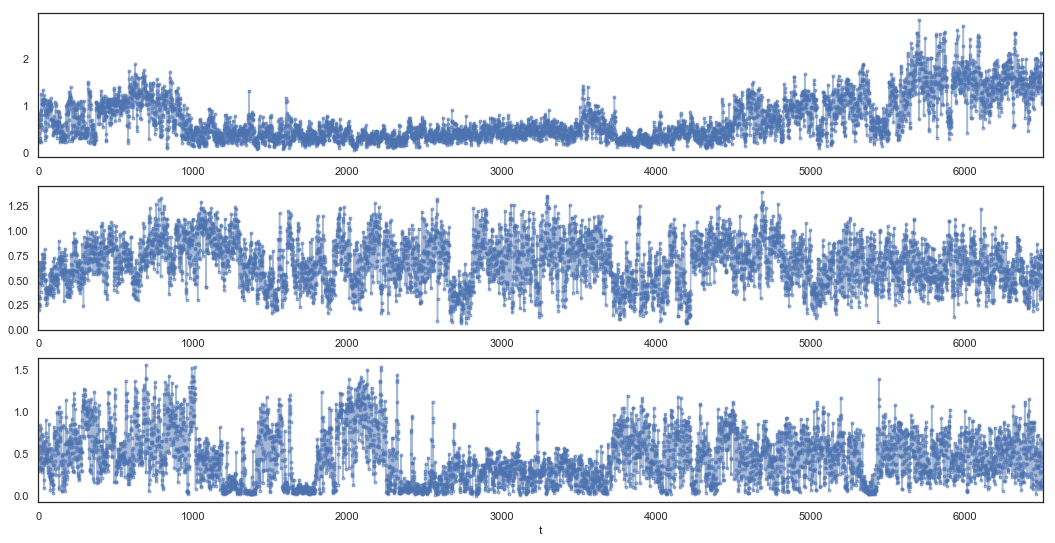

In [27]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[sel0,0]/ampst[sel0,1]>0.4)*(ampst[sel0,0]/ampst[sel0,1]<1.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(sel.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [1992  220  131]


Text(0.5,0,'t')

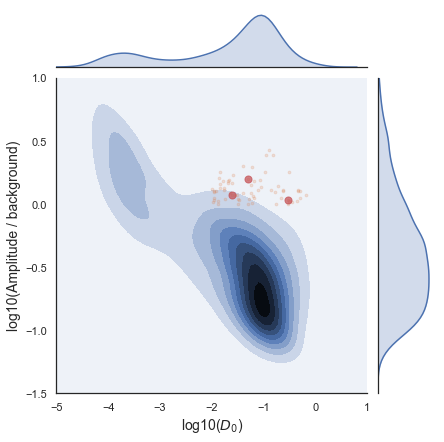

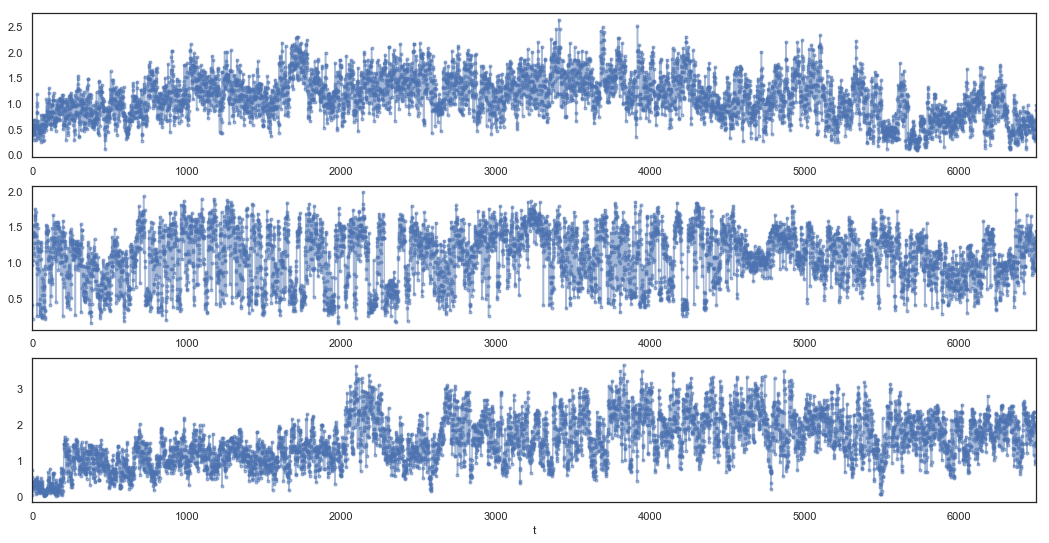

In [28]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[sel0,0]/ampst[sel0,1]>1.0)*(ampst[sel0,0]/ampst[sel0,1]<3.0)*(Des[:,0]>1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(sel.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [1924  116   74]


Text(0.5,0,'t')

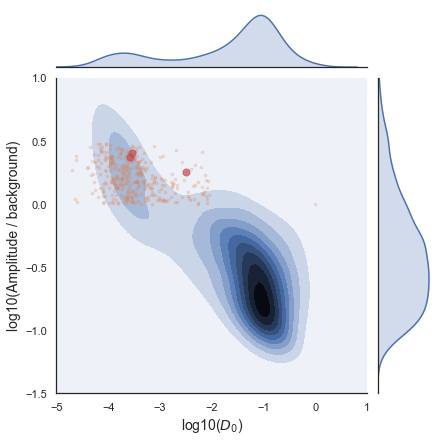

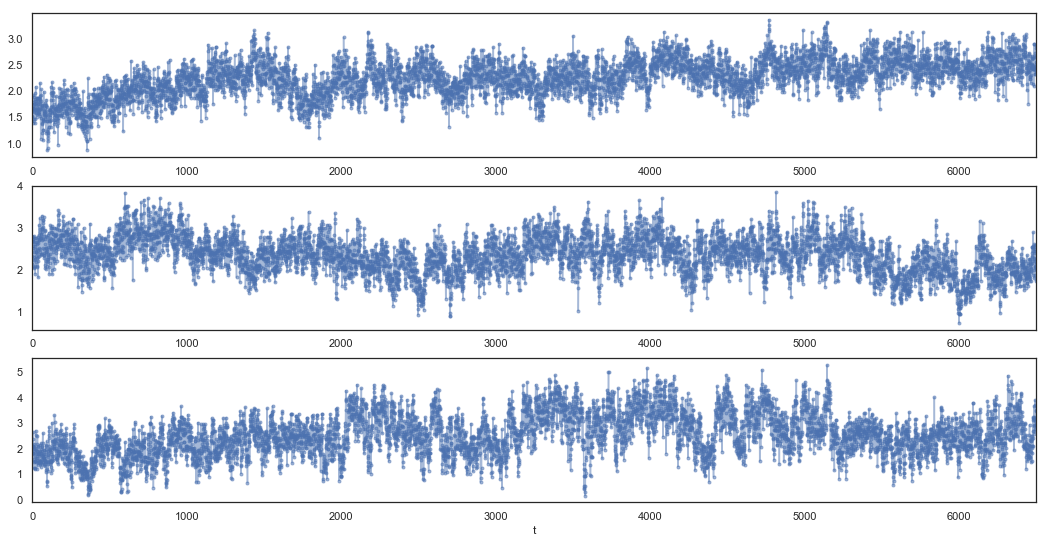

In [29]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[sel0,0]/ampst[sel0,1]>1.0)*(ampst[sel0,0]/ampst[sel0,1]<3.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(sel.shape[0])[sel])[:3]
#fig = figure(figsize=(14,8))
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [  16   21 1788]


Text(0.5,0,'t')

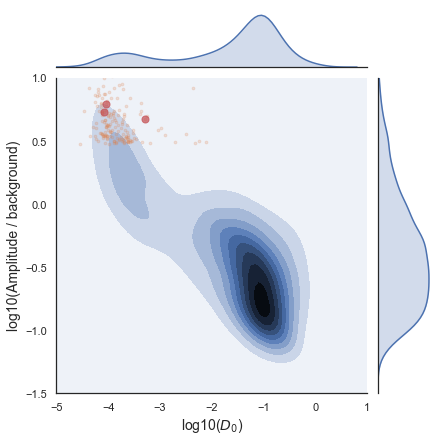

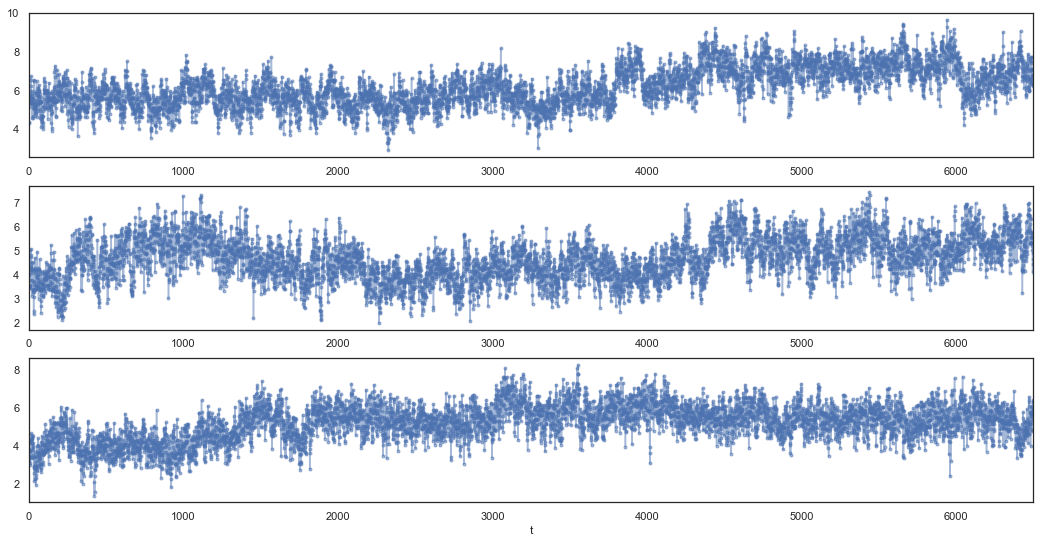

In [31]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[sel0,0]/ampst[sel0,1]>3.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(sel.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [ ]:
yt = 1.0*ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])

In [ ]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(ampst[:,0]/ampst[:,1]<1.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [ ]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

In [ ]:
print(len(yt))

In [ ]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(it):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [ ]:
ampst[2317,2]

In [ ]:
figure(figsize=(18,6))
i = 2317
name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
xlim(0,6500)
figure(figsize=(18,6))
hist(amp[sel],31)

In [ ]:
bimod(amp[sel])

In [ ]:
name = dfiles[i+2]
popts = load(name)
posx = popts[:,5]
posy = popts[:,6]
amp = popts[:,0]
th = 0
th2 = 13.0
sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
Tf = len(posx)
temp = [mean(amp[sel]),mean(popts[sel,4]),bimod(amp[sel])]

In [ ]:
temp

In [ ]:
ampst[2317,1]